# Análise de Retenção de Clientes com Regressão Logística

**Tarefa 5 da disciplina Análise Estatística de Dados e Informações, ministrada por João Gabriel de Moraes Souza**

**Aluno**: Adam Victor Nazareth Brandizzi

## Introdução

A retenção de clientes é um termo que refere-se tanto a uma métirca que avaialia quantos clientes permanecem ligados a uma instituição quanto procedimentos tomados para manter ou incrementar esta métrica. Isto ocorre porque o processo de aquisição de clientes é geralmente muito mais caro que a manutenção, e uma alta evasão (comumente chamada *churn*) pode indicar problemas fundamentais em uma empresa.

Neste trabalho, avaliaremos as estatísticas de clientes de uma instituição bancária, tentando identificar que fatores podem levar a uma evasão maior ou menor. Para isto, vamos utilizar a base [Predicting Churn for Bank Customers](https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers?resource=download).

## Análise exploratória inicial

In [1]:
import pandas as pd
df = pd.read_csv('./Churn_Modelling.csv')
df.infer_objects(copy=False)
pd.DataFrame(dict(columns=df.columns))

,columns
0,RowNumber
1,CustomerId
2,Surname
3,CreditScore
4,Geography
5,Gender
6,Age
7,Tenure
8,Balance
9,NumOfProducts


As colunas `RowNumber`, `CustomerId` e `Surname` podem, razoavelmente, ser descartadas sem grande análise: não esperamos que o nome ou o identificador (arbitrário) do cliente acrescentaria muita informação. A coluna `Exited` contém a variável dependente que desejamos prever, e as demais, as variáveis independentes (i.e. fatores) que temos disponíveis.

In [2]:
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1).copy()
Y = df['Exited'].astype(int).copy()
factors = X.columns
output_column = Y.name
relevant_columns = list(factors) + [output_column]

Vale a pena observar se as colunas possuem valores nulos (i.e.  `nan`, `null` etc.) como valores:

In [3]:
pd.DataFrame({
    'factor': relevant_columns,
    'null': [df[c].isnull().any() for c in relevant_columns]
})


,factor,null
0,CreditScore,False
1,Geography,False
2,Gender,False
3,Age,False
4,Tenure,False
5,Balance,False
6,NumOfProducts,False
7,HasCrCard,False
8,IsActiveMember,False
9,EstimatedSalary,False


Felizmente, todas as linhas estão com suas colunas propriamente preenchidas.

Note que, dos fatores restantes, dois são categóricos:  `Geography` e `Gender`. Vamos tomar nota, pois eventualmente teremos de codificá-los em valores numéricos.


In [4]:
categorical_factors = ['Geography', 'Gender']
numeric_factors = [f for f in X.columns if f not in categorical_factors and f != 'const']
X_raw = X
X = pd.get_dummies(X, columns=categorical_factors, drop_first=True, dtype=int)
relevant_columns_one_hot = [
    c for c in X.columns if any(c.startswith(rc) for rc in relevant_columns)
]

Façamos então uma breve análise exploratória de cada fator.

## `Geography`

Os clientes vêm de locais diferentes. Estas são as localições encontradas na base:

In [5]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def count_exited(X, Y, factor):
    counting = pd.DataFrame(X[factor].value_counts())
    counting['Exited'] = [
        sum(Y[X[factor] == c]) for c in counting.index
    ]
    counting["Stayed"] = counting.iloc[:, 0] - counting["Exited"]
    counting["Exited%"] = counting["Exited"] / counting.iloc[:, 0]
    counting["Stayed%"] = counting["Stayed"] / counting.iloc[:, 0]
    return counting

def binned_counting(counting, factor_name, num_bins):
    bins = np.linspace(
        counting.index.min(),
        counting.index.max(),
        num_bins + 1
    )

    counting = counting.copy()
    counting['bin'] = pd.cut(counting.index, bins, include_lowest=True)
    #return counting
    groups = counting.groupby('bin', observed=True)
    groups_medians = groups['bin'].first().apply(lambda x: x.mid).astype(float)
    exited_count = groups['Exited'].sum()
    #return exited_count
    stayed_count = groups['Stayed'].sum()
    total_count = exited_count + stayed_count

    counting = pd.DataFrame({
        'count': total_count,
        factor_name: groups_medians,
        'Exited': exited_count,
        'Stayed': stayed_count,
        'Exited%': exited_count / total_count,
        'Stayed%': stayed_count / total_count,
    }, index=groups_medians)
    return counting
#binned_counting(balance_counting, 'Balance', 10)


In [6]:
def plot_counting(title, counting, format='bar', proportional=True):
    factor_name = counting.index.name or 'Value'
    title = title or f"Proportion of Exited vs Stayed by {factor_name}"

    suffix = '%' if proportional else ''
    

    df = counting.reset_index().melt(
        id_vars=factor_name,
        value_vars=[f'Exited{suffix}', f'Stayed{suffix}'],
        var_name="Status",
        value_name="Proportion"
    )
    
    fig = None
    if format == 'bar':
        fig = px.bar(
            df,
            x=factor_name,
            y="Proportion",
            color="Status",
            title=title,
            text=df["Proportion"].apply(lambda x: f"{float(x):.0{suffix or 'f'}}"),
        )
    elif format == 'area':
        fig = px.area(
            df,
            x=factor_name,
            y="Proportion",
            color="Status",
            title=title,
        )
    
    fig.update_layout(
        yaxis=dict(title=title, tickformat=f".0{suffix}"),
        xaxis_title=factor_name,
        legend_title="Status",
        hovermode="x unified",
        height=500,
    )

    fig.show()
    return counting
    

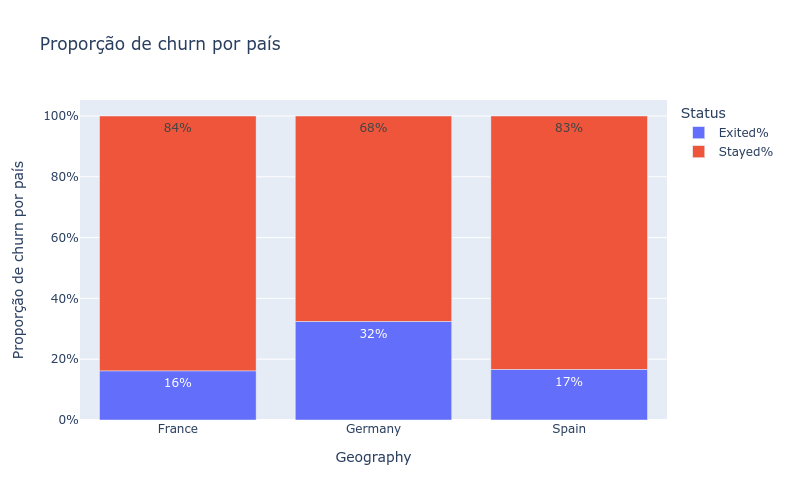

,count,Exited,Stayed,Exited%,Stayed%
Geography,,,,,
France,5014,810,4204,0.161548,0.838452
Germany,2509,814,1695,0.324432,0.675568
Spain,2477,413,2064,0.166734,0.833266


In [7]:
geography_counting = count_exited(X_raw, Y, 'Geography')

plot_counting('Proporção de churn por país', geography_counting)

O fato de haver um churn maior na Alemanha indica que essa propriedade pode ter informações importantes para previsão.

## Gender

No que tange a gênero, notamos que mulheres tendem a fechar suas contas mais que homens proporcionalmente falando.

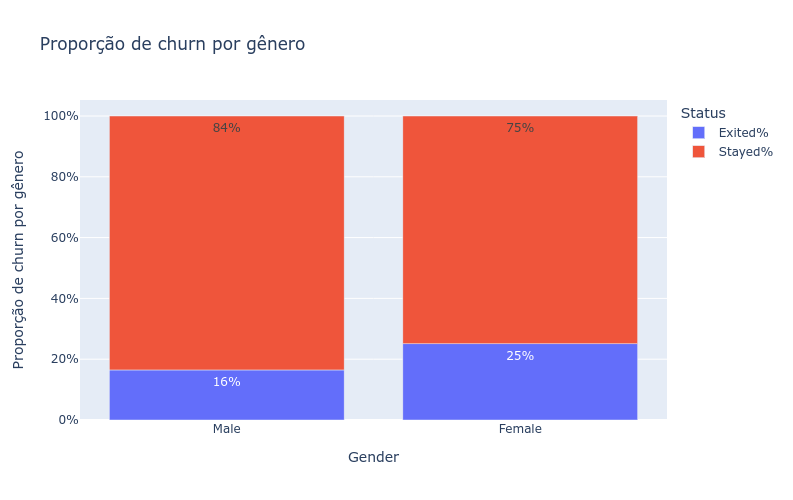

,count,Exited,Stayed,Exited%,Stayed%
Gender,,,,,
Male,5457,898,4559,0.164559,0.835441
Female,4543,1139,3404,0.250715,0.749285


In [8]:
gender_counting = count_exited(X_raw, Y, 'Gender')
plot_counting('Proporção de churn por gênero', gender_counting)

## Age



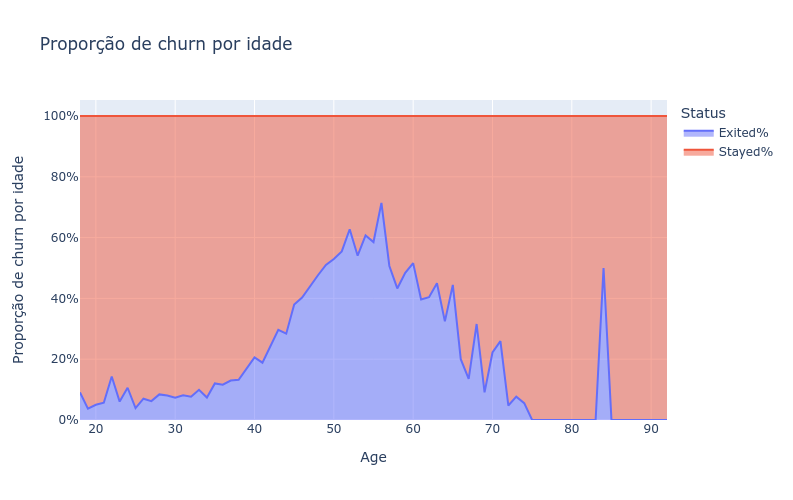

In [9]:
age_counting = count_exited(X_raw, Y, 'Age')
_ = plot_counting('Proporção de churn por idade', age_counting, format='area')

Notamos que a proporção tende a ter uma forma normal ligeiramente viesada para a esquerda, exceto por um pico outlier causado na idade de 84 anos, quando há apenas dois clientes, e um deles saiu:

In [10]:
X_raw[X_raw['Age']==84]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98
3531,408,France,Female,84,8,87873.39,1,0,0,188484.52


Como o outlier afeta a regressão? Vamos fazer um teste de regressão logística com e sem outlier:

In [11]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import textwrap


def compare_models(X, Y, X_prime, Y_prime):
    full_model = sm.Logit(Y, X).fit(disp=False)
    alternative_model = sm.Logit(Y_prime, X_prime).fit(disp=False)

    print(
        'Full dataset:', full_model.params,
        'Alt dataset:', alternative_model.params,
        sep='\n'
    )

    full_prediction = full_model.predict(X)
    alternative_prediction = alternative_model.predict(X_prime)
    print("AUC full:", roc_auc_score(Y, full_prediction))
    print("AUC alt:", roc_auc_score(Y_prime, alternative_prediction))
    return full_model, alternative_model

def compare_outlier(X, Y, factor, outliers):
    F = sm.add_constant(X[factor])
    full_model = sm.Logit(Y, F).fit(disp=False)

    F_prime = F[~(F[factor].isin(outliers))]
    Y_prime = Y[~(F[factor].isin(outliers))]
    return compare_models(F, Y, F_prime, Y_prime)


_ = compare_outlier(X, Y, 'Age', outliers=[84])

Full dataset:
const   -3.928603
Age      0.062945
dtype: float64
Alt dataset:
const   -3.934058
Age      0.063084
dtype: float64
AUC full: 0.7320707498986938
AUC alt: 0.7320313606526877


O outlier claramente não afetou drasticamente o modelo, de modo que acreditamos não ser necessário removê-lo.

## Tenure

Antes de investigarmos o tempo de conta ("tenure"), vamos verificar um ponto importante. Idade e tempo de conta têm o potencial de terem alta colinearidade. Como são apenas dois valores, demos verificar isso de maneira simples, observando a matriz de correlação:

In [12]:
X_raw[['Age', 'Tenure']].corr()

,Age,Tenure
Age,1.000000,-0.009997
Tenure,-0.009997,1.000000


Os valores de correlação entre eles são bem baixos ($9.9 \times 10^{-3}$), então não nos preocuparemos com isso: consideraremos ambos não lineares entre si.

Como é o comportamento de churn para os vários valores de tenure? Vejamos no gráfico da proporção de clientes:

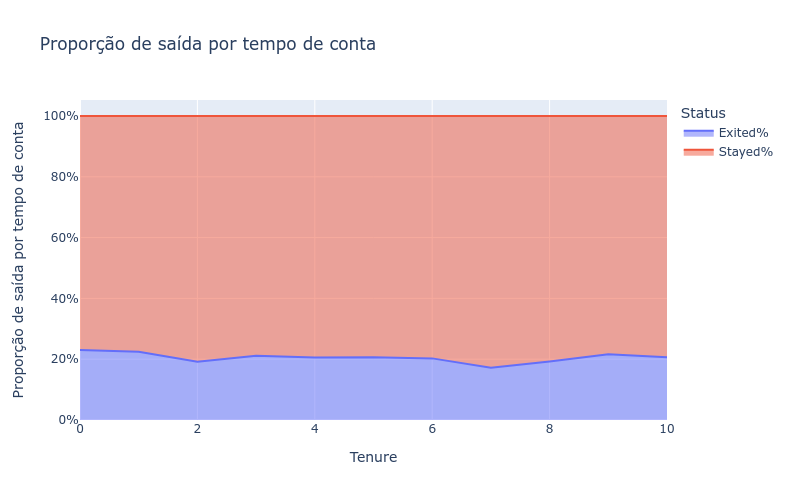

,count,Exited,Stayed,Exited%,Stayed%
Tenure,,,,,
2,1048,201,847,0.191794,0.808206
1,1035,232,803,0.224155,0.775845
7,1028,177,851,0.172179,0.827821
8,1025,197,828,0.192195,0.807805
5,1012,209,803,0.206522,0.793478
3,1009,213,796,0.211100,0.788900
4,989,203,786,0.205258,0.794742
9,984,213,771,0.216463,0.783537
6,967,196,771,0.202689,0.797311


In [13]:
tenure_counting = count_exited(X_raw, Y, 'Tenure')
plot_counting('Proporção de saída por tempo de conta', tenure_counting, format='area')

Esse fator parece ter uma variabilidade muito baixa. Vale a pergunta: ele é explicativo? Vamos fazer um teste, gerando regressões com e sem esse fator:

In [14]:
 def compare_factor_relevance(X, Y, factors):
     X_prime = X.drop(factors, axis=1)
     return compare_models(X, Y, X_prime, Y)
    

full_model, no_tenure_model = compare_factor_relevance(X, Y, ['Tenure'])

print('Tenure coefficient p-value:\t', full_model.pvalues['Tenure'])

Full dataset:
CreditScore         -3.580994e-03
Age                  5.864804e-02
Tenure              -3.989666e-02
Balance              9.639830e-07
NumOfProducts       -3.309228e-01
HasCrCard           -1.938248e-01
IsActiveMember      -1.073570e+00
EstimatedSalary     -8.485554e-07
Geography_Germany    7.886971e-01
Geography_Spain     -4.151419e-02
Gender_Male         -6.193472e-01
dtype: float64
Alt dataset:
CreditScore         -3.747778e-03
Age                  5.778460e-02
Balance              8.684995e-07
NumOfProducts       -3.460622e-01
HasCrCard           -2.080425e-01
IsActiveMember      -1.065335e+00
EstimatedSalary     -9.539115e-07
Geography_Germany    7.870871e-01
Geography_Spain     -4.408112e-02
Gender_Male         -6.282132e-01
dtype: float64
AUC full: 0.7466469091122288
AUC alt: 0.7451557217471997
Tenure coefficient p-value:	 1.1017943687654043e-05


O tempo de conta tem um p-valor baixo, o que nos leva a rejeitar a hipótese de coeficiente nulo para esse fator.  Mas no teste que fizemos, o impacto foi pequeno, da ordem de $10^{-3}$. Isso parece evidência de que esse coeficiente pode ser dispensado.

Por ora, vamos tomar nota deste comportamento para posteriormente fazer uma comparação do impacto de todos os fatores.

## Saldo

O saldo ("Balance") é um fator que, intuitivamente, afetaria o comportamento bastante. Vamos ver como a proporção de saída se comporta com esse dado. Como há muitos valores, vamos fazer um gráfico com binning:

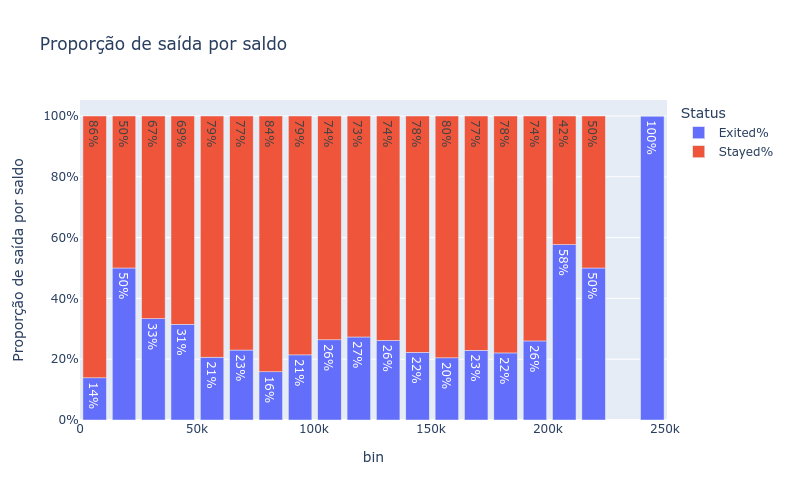

,count,Balance,Exited,Stayed,Exited%,Stayed%
bin,,,,,,
6272.4515,3619,6272.4515,502,3117,0.138712,0.861288
18817.3565,4,18817.3565,2,2,0.500000,0.500000
31362.2615,15,31362.2615,5,10,0.333333,0.666667
43907.1660,54,43907.1660,17,37,0.314815,0.685185
56452.0705,121,56452.0705,25,96,0.206612,0.793388
68996.9750,239,68996.9750,55,184,0.230126,0.769874
81541.8795,454,81541.8795,72,382,0.158590,0.841410
94086.7840,719,94086.7840,154,565,0.214186,0.785814
106631.6885,997,106631.6885,263,734,0.263791,0.736209


In [15]:
balance_counting = count_exited(X_raw, Y, 'Balance')
binned_balance_counting = binned_counting(balance_counting, 'Balance', num_bins=20)
plot_counting('Proporção de saída por saldo', binned_balance_counting)

Nota-se grande variedade de proporções, o que pode indicar um bom poder explicativo para esse fator. Contudo, um detalhe estranho pode ser notado na tabela: há um número enorme de valores no primeiro bin, quase um terço do total. Vamos analisar o que se passa:

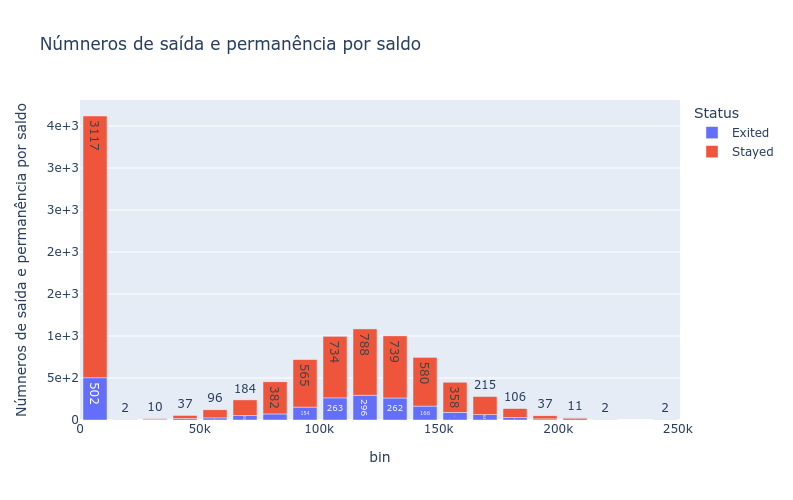

In [16]:
_ = plot_counting('Númneros de saída e permanência por saldo', binned_balance_counting, proportional=False)

Há um número muito grande de valores no primeiro quantil. Ao investigarmos, notamos que são majoritarialmente saldos zerados:

In [17]:
binned_balance_counting.head(n=5)

,count,Balance,Exited,Stayed,Exited%,Stayed%
bin,,,,,,
6272.4515,3619,6272.4515,502,3117,0.138712,0.861288
18817.3565,4,18817.3565,2,2,0.500000,0.500000
31362.2615,15,31362.2615,5,10,0.333333,0.666667
43907.1660,54,43907.1660,17,37,0.314815,0.685185
56452.0705,121,56452.0705,25,96,0.206612,0.793388


Isso nos traz uma preocupação: será que esse desbalanceamento poderia causar problemas? Em princípio, não: regressão logística não é impactada por valores repetidos, mas se esses valores tiverem uma influencia muito grande sobre a previsão, será necessário tratá-los. Para verificar isso, vamos observar a variação de proporção entre os dois grupos:

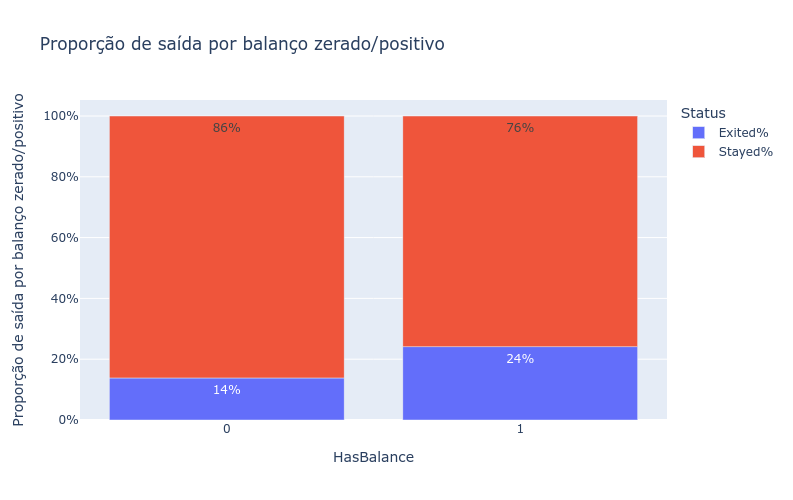

,count,Exited,Stayed,Exited%,Stayed%
HasBalance,,,,,
1,6383,1537,4846,0.240796,0.759204
0,3617,500,3117,0.138236,0.861764


In [18]:
X['HasBalance'] = (X['Balance'] != 0).astype(int)

has_balance_counting = count_exited(X, Y, 'HasBalance')
plot_counting('Proporção de saída por balanço zerado/positivo', has_balance_counting)

Há uma diferença entre as proporções, vamos incluir a flag `HasBalance` nos dados, e analisar os coeficentes quando fizermos a regressão desejada. Deste modo, vamos separar o peso do tamanho do saldo e o peso do fato de não haver saldo. Ao comparar os coeficentes, teresmo mais ciência da relevância de ambos.

## EstimatedSalary

Vejamos agora o possível efeito do salário estimado. Novamente, vamos usar valores em baldes para análise preliminar:



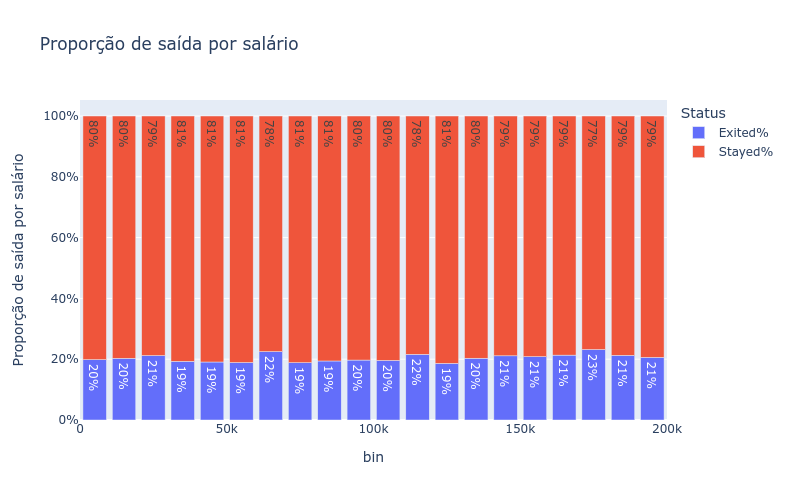

,count,EstimatedSalary,Exited,Stayed,Exited%,Stayed%
bin,,,,,,
5011.1020,509,5011.1020,101,408,0.198428,0.801572
15010.1475,478,15010.1475,97,381,0.202929,0.797071
25009.1925,491,25009.1925,104,387,0.211813,0.788187
35008.2375,477,35008.2375,92,385,0.192872,0.807128
45007.2825,498,45007.2825,95,403,0.190763,0.809237
55006.3275,508,55006.3275,96,412,0.188976,0.811024
65005.3725,507,65005.3725,114,393,0.224852,0.775148
75004.4175,520,75004.4175,98,422,0.188462,0.811538
85003.4625,510,85003.4625,99,411,0.194118,0.805882


In [19]:
estimated_salary_counting = count_exited(X_raw, Y, 'EstimatedSalary')
binned_estimated_salary_counting = binned_counting(estimated_salary_counting, 'EstimatedSalary', num_bins=20)
plot_counting('Proporção de saída por salário', binned_estimated_salary_counting)

À primeira vista, o salário estimado não adiciona muita variância na probabilidade de saída, então não possui muita informação. Considerando que temos outras variáveis de interesse, **não vamos utilizar salário**.

## CreditScore

O _score_ de crédito é outra variável numérica que parece interessante. Verifiquemos o quanto ela afeta as proporções:

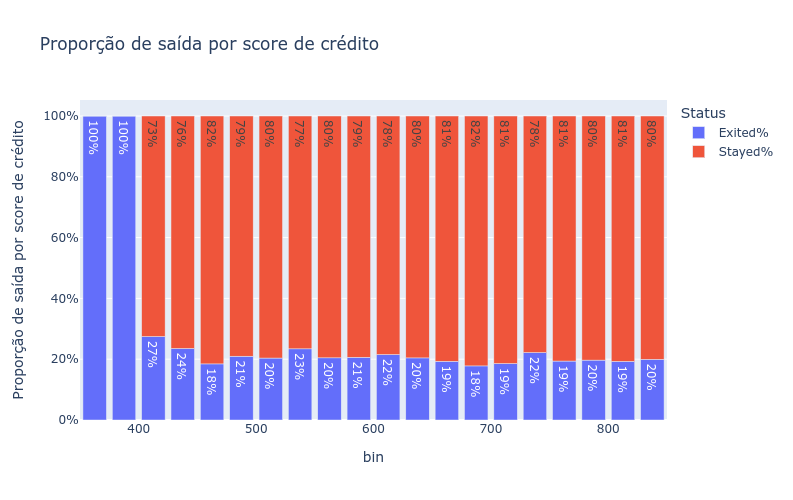

,count,CreditScore,Exited,Stayed,Exited%,Stayed%
bin,,,,,,
362.4995,12,362.4995,12,0,1.000000,0.000000
387.5000,7,387.5000,7,0,1.000000,0.000000
412.5000,51,412.5000,14,37,0.274510,0.725490
437.5000,119,437.5000,28,91,0.235294,0.764706
462.5000,168,462.5000,31,137,0.184524,0.815476
487.5000,286,487.5000,60,226,0.209790,0.790210
512.5000,427,512.5000,87,340,0.203747,0.796253
537.5000,551,537.5000,129,422,0.234120,0.765880
562.5000,621,562.5000,127,494,0.204509,0.795491


In [20]:
credit_score_counting = count_exited(X_raw, Y, 'CreditScore')
binned_credit_score_counting = binned_counting(credit_score_counting, 'CreditScore', num_bins=20)
plot_counting('Proporção de saída por score de crédito', binned_credit_score_counting)

Os valores mais baixos resultam em altíssimo churn; absoluto, na verdade. Isso pode enviesar um modelo para reagir drasticamente a esses valores. Uma solução é regularizar, como veremos no próximo fator.

## NumOfProducts

Como o número de produtos afetar o desempenho?

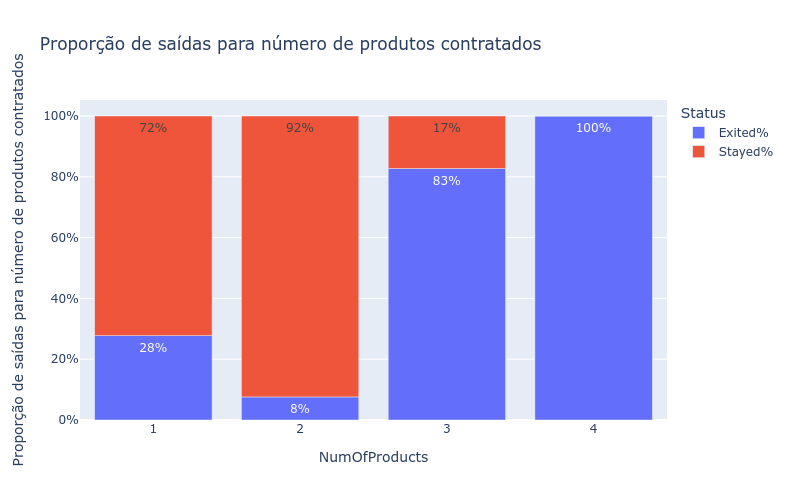

,count,Exited,Stayed,Exited%,Stayed%
NumOfProducts,,,,,
1,5084,1409,3675,0.277144,0.722856
2,4590,348,4242,0.075817,0.924183
3,266,220,46,0.827068,0.172932
4,60,60,0,1.000000,0.000000


In [21]:
num_of_products_counting = count_exited(X, Y, 'NumOfProducts')
plot_counting('Proporção de saídas para número de produtos contratados', num_of_products_counting)

O fato de clientes com o número máximo de produtos (4), todos, cancelarem suas contas é interessante. Talvez clientes que sejam mais sofisticados saibam aproveitar melhor as vantagens de bancos diferentes? Talvez tenham se sentido pressionados a contratar, e isso prejudicou o relacionamento com o banco?

Isso pode ter sido até mesmo um **artefato da geração da amostra** ou, até mais plausível: **um erro de entrada**! Considerando que são apenas 60 clientes, uma pesquisa qualitativa seria bem-vinda.

Para nós, a maior preocupação é como isso pode afetar nosso modelo. Se utilizássemos `NumOfProducts` como categorias (i.e. separado por one-hot encoding), o modelo certamente daria coeficientes extremos para o valor 4. Mas escolhemos utilizar o número de produtos como um valor numérico mesmo, já que não existe uma diferença qualitativa entre os números de produtos.

Como vantagem extra, o coeficiente não é afetado extremamente pelas proporções exageradas quando o valor é 4. Podemos verificar isso facilmente fazendo uma regressão e checando os coeficientes e desvios-padrão:

In [22]:
num_of_products_model = sm.Logit(Y, X)
num_of_products_result = num_of_products_model.fit()
num_of_products_result.summary()

Optimization terminated successfully.
         Current function value: 0.437989
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9988
Method:                           MLE   Df Model:                           11
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.1335
Time:                        23:56:01   Log-Likelihood:                -4379.9
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                7.323e-283
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CreditScore          -0.0036      0.000    -18.600      0.000      -0.004      -0.003
Age                   0.0587      0.002     25.051      0.000       0.054       0.063
Tenure               -0.0398      0.009     -4.384      0.000      -0.058      -0.022
Balance            1.684e-06   1.08e-06      1.560      0.119   -4.32e-07     3.8e-06
NumOfProducts        -0.3347      0.045     -7.376      0.000      -0.424      -0.246
HasCrCard            -0.1936      0.057     -3.403      0.001      -0.305      -0.082
IsActiveMember       -1.0731      0.056    -18.996      0.000      -1.184      -0.962
EstimatedSalary   -8.398e-07   4.57e-07     -1.836      0.066   -1.74e-06    5.68e-08
Geography_Germany     0.7996      0.069     11.604      0.000       0.665       0.935
Geography_Spain      -0.0413      0.069     -0.594      0.552      -0.177       0.095
Gender_Male          -0.6192      0.053    -11.613      0.000      -0.724      -0.515
HasBalance           -0.1098      0.146     -0.750      0.453      -0.397       0.177
=====================================================================================
"""

O coeficiente e o desvio-padrão dessa regressão experimental foram baixos para o fator `NumOfProducts`, então não vamos nos preocupar com essa peculiar propriedade deste fator. Ainda assim, **adicionaremos uma regularização** ao modelo final, para prevenir overfitting.

## HasCreditCard

Agora, verificaremos mais duas variáveis booleanas. Primeiramente, como a possie de um cartão de crédito afeta o churn?

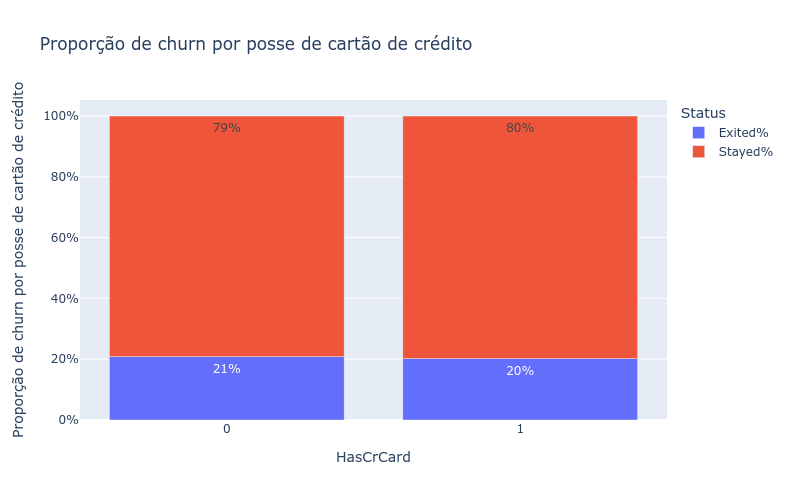

,count,Exited,Stayed,Exited%,Stayed%
HasCrCard,,,,,
1,7055,1424,5631,0.201843,0.798157
0,2945,613,2332,0.208149,0.791851


In [23]:
has_cr_card_counting = count_exited(X, Y, 'HasCrCard')
plot_counting('Proporção de churn por posse de cartão de crédito', has_cr_card_counting)

A saída é curiosamente balanceada em função da posse de cartão de crédito, mas há claramente um efeito. Esta é uma propriedade interessante a se incluir.

## IsActiveMember

A outra propriedade booleana é o status de atividade. Se o cliente é ativo, como isso afeta a probabilidade de cancelamento de conta?

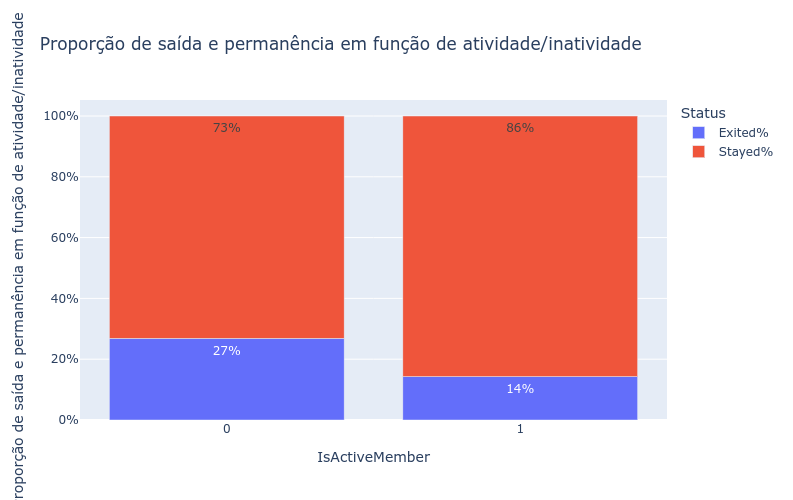

,count,Exited,Stayed,Exited%,Stayed%
IsActiveMember,,,,,
1,5151,735,4416,0.142691,0.857309
0,4849,1302,3547,0.268509,0.731491


In [24]:
is_active_member_counting = count_exited(X, Y, 'IsActiveMember')
plot_counting('Proporção de saída e permanência em função de atividade/inatividade', is_active_member_counting)

Usuários inativos têm mais probabilidade de cancelar a conta, o que faz sentido. Esse certametne é um fator a se incluir na regressão.

## Conclusão de análise de fatores

Com essa breve análise, nos parece que alguns fatores interessantes a incluir são o saldo (mas junto com um fator booleano para isolar a influência de valores zerados), número de produtos e _score_ de crédito; complementados com idade, gênero e região:

In [25]:
selected_columns = ['Age', 'Balance', 'NumOfProducts', 'CreditScore', 'Age', 'Gender', 'Geography']
selected_columns_one_hot = [
    c for c in X if any(c.startswith(sc) for sc in selected_columns)
]
X = X[selected_columns_one_hot]
X

,CreditScore,Age,Balance,NumOfProducts,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,0.00,1,0,0,0
1,608,41,83807.86,1,0,1,0
2,502,42,159660.80,3,0,0,0
3,699,39,0.00,2,0,0,0
4,850,43,125510.82,1,0,1,0
...,...,...,...,...,...,...,...
9995,771,39,0.00,2,0,0,1
9996,516,35,57369.61,1,0,0,1
9997,709,36,0.00,1,0,0,0
9998,772,42,75075.31,2,1,0,1


# Análise de pré-requisitos

Para avaliar como melhor utilizar essas variáveis, vamos executar dois procedimentos:

- verificar se a base está balanceada e, se não, balanceá-la; e
- verificar os pré-requisitos dos fatores para regressão logística.

### Balanceamento da base

Verifiquemos se a base está balanceada:

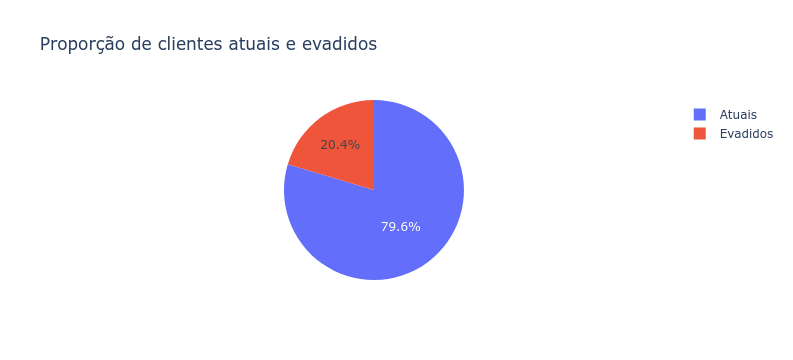

,counts
Exited,
0,7963
1,2037


In [26]:
def show_dataset_balance(df):
    counts = df.value_counts()
    counts_df = pd.DataFrame(dict(counts=counts), index=counts.index)
    counts_graph = px.pie(
        title='Proporção de clientes atuais e evadidos',
        values=counts_df['counts'],
        names=['Atuais', 'Evadidos']
    )
    counts_graph.show()
    return counts_df

show_dataset_balance(Y)

Claramente, temos cinco clientes que não saíram para cada cliente que saiu. Isso é desbalanceado, então vamos balancear a base utilizndo [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html).

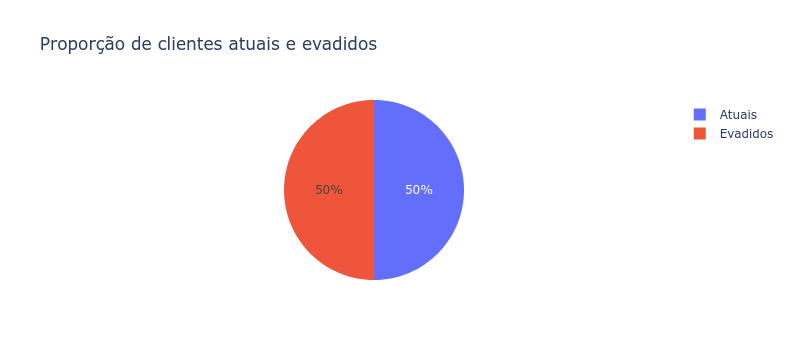

,counts
Exited,
1,7963
0,7963


In [27]:
from imblearn.over_sampling import SMOTENC

selected_categorical_columns_one_hot = [
    c for c in selected_columns_one_hot
        if any(c.startswith(cc) for cc in categorical_factors)
]

smotenc = SMOTENC(categorical_features=selected_categorical_columns_one_hot, random_state=42)
X, Y = smotenc.fit_resample(X, Y)

show_dataset_balance(Y)

Com a base balanceada, podemos prosseguir para analisar os pré-requisitos da regressão logística:
- ausência de colinearidade entre fatoreds;
- linearidade entre fatores e o logit das razões de chances.

### Colinearidade

A colinearidade pode ser verificada utilizando o [fator de inflação de variância](https://www.datacamp.com/pt/tutorial/variance-inflation-factor).

In [28]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif[vif['feature'] != 'const']

,feature,VIF
0,CreditScore,19.589060
1,Age,13.528647
2,Balance,3.494186
3,NumOfProducts,6.748858
4,Geography_Germany,2.013825
5,Geography_Spain,1.420842
6,Gender_Male,1.938688


Como todos os valores estão bem próximos de 1, é razoável assumir que nenhum campo tem alta colinearidade, então podemos escolher quaisquer uns deles.

## Linearidade com o logit da probabilidade

Outro pré-requisito para regressão logística é uma relação quase linear entre os fatores e o log da razão de chance (i.e. a logit da probabilidade):

$$
X_1, X_2, ..., X_n \sim_{linear} Y
$$

Para verificar isso, vamos utilizar o [teste de Box-Tidwell](https://archive.org/details/logisticregressi0000ocon/page/44/mode/2up?q=%22box-tidwell%22). Esses são os passos do teste:

1. selecione apenas as colunas dos fatores contínuos;
2. selecione apenas as linhas em que todos os valores são positivos (no nosso caso, desnecessário, pois todos já são positivos);
3. para cada coluna original, adicione outra com o log natural dela;
4. para cada coluna original, adicione outra (chamada de "interação") com o produto do valor original pelo log do valor original;
5. treinamos uma regressão logística com esse novo dataset.
6. verificamos os coeficientes: se algum coeficiente de alguma interação for grande, isso indica não-linearidade da coluna original correspondente.

Aqui executamos os passos:

In [29]:
import numpy as np

numeric_columns = ['Age', 'Balance', 'NumOfProducts']

def box_tidwell(X, Y, output_column='Exited', columns=numeric_factors):
    X = X[columns].copy()
    for c in X.columns:
        # We have many columns that are closer to the constant, so we
        # normalize colinearity with the constant
        X[c] = (X[c] - X[c].mean()) / X[c].std()
        X[c] = X[c] - X[c].min() + 1e-6
        # We add a very small positive constant to avoid zeros in the
        # values.
        X[f'{c}:interaction'] = X[c] * np.log(X[c].replace(0, 1e-6))
    model = sm.Logit(Y, X)
    result = model.fit()
    return result

def box_tidwell_multiple(X, Y, columns):
    bt_df = pd.DataFrame({
        'factor': [],
        'pvalue': []
    })
    for i, col in enumerate(columns):
        res = box_tidwell(X, Y, columns=[col])
        interaction = f'{col}:interaction'
        bt_df.loc[i] = [interaction, res.pvalues[interaction]]
    return bt_df

box_tidwell_multiple(X, Y, numeric_columns)

Optimization terminated successfully.
         Current function value: 0.652715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627432
         Iterations 7


,factor,pvalue
0,Age:interaction,5.226518e-187
1,Balance:interaction,7.592748e-01
2,NumOfProducts:interaction,1.436720e-166


Nenhum dos valores apresenta linearidade. Vejamos como se dá a relação com o churn:

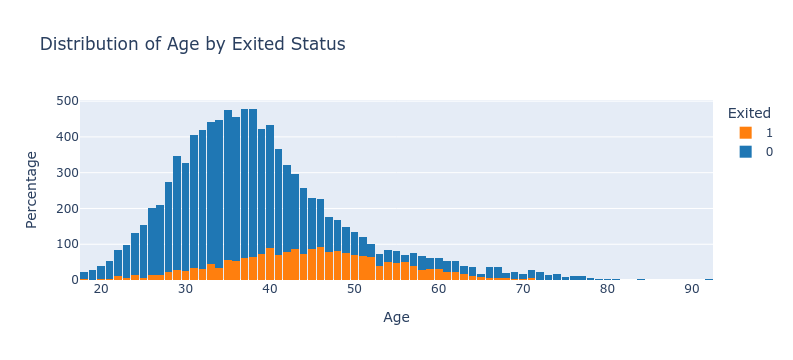

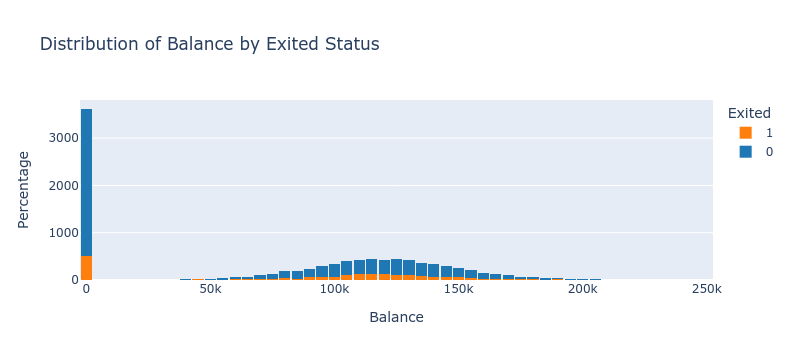

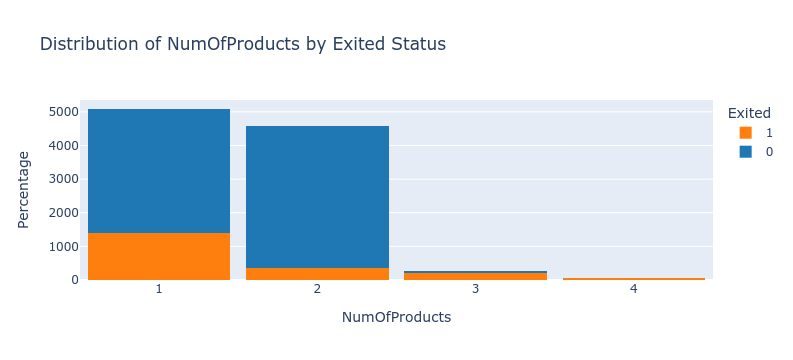

In [30]:
for col in numeric_columns:
    fig = px.histogram(
        df,
        x=col,
        color='Exited',
        barmode='stack',
        title=f'Distribution of {col} by Exited Status',
        color_discrete_map={0: '#1f77b4', 1: '#ff7f0e'}  # optional: blue/orange
    )
    fig.update_layout(
        yaxis_title='Percentage',
        bargap=0.1
    )
    fig.show()


Podemos experimentar transformações para tentar encontrar linearidades.

In [31]:
def box_tidwell_transform(X, Y, columns, f):
    X = X.copy()
    for c in columns:
        X[c] = f(X[c])
    return box_tidwell_multiple(X, Y, columns)

Comecemos considerando o logaritmo das propriedades:

In [32]:
box_tidwell_transform(X, Y, numeric_columns, lambda v: np.log(v+1))

Optimization terminated successfully.
         Current function value: 0.629958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627441
         Iterations 7


,factor,pvalue
0,Age:interaction,0.000000e+00
1,Balance:interaction,1.285918e-01
2,NumOfProducts:interaction,5.688863e-150


Nenhuma coluna de interação apresentou linearidade, o que é um bom sinal. Vamos rodar o modelo e verificar seu comportamento.

# Avaliação de modelo

Com o que temos, vamos avaliar o modelo:

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = sm.Logit(Y_train, X_train)
# Using regularized models due to skewed values such as CreditScore,
# and NumOfProducts
result = model.fit_regularized(penalty='elastic_net', alpha=1.0, L1_wt=0.0)
result.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5702811849003179
            Iterations: 59
            Function evaluations: 75
            Gradient evaluations: 59


/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 7 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/home/adam/lib/virtualenv/data-mining-experiments/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Exited   No. Observations:                12740
Model:                          Logit   Df Residuals:                    12733
Method:                           MLE   Df Model:                            6
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.1776
Time:                        23:56:03   Log-Likelihood:                -7262.4
converged:                       True   LL-Null:                       -8830.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
CreditScore          -0.0023      0.000    -16.311      0.000      -0.003      -0.002
Age                   0.0706      0.002     35.838      0.000       0.067       0.074
Balance            -1.75e-07   3.62e-07     -0.483      0.629   -8.85e-07    5.35e-07
NumOfProducts        -0.8633      0.035    -24.643      0.000      -0.932      -0.795
Geography_Germany     0.9207      0.050     18.322      0.000       0.822       1.019
Geography_Spain      -0.3804      0.053     -7.120      0.000      -0.485      -0.276
Gender_Male          -0.7301      0.040    -18.243      0.000      -0.809      -0.652
=====================================================================================
"""

Coeficientes têm valores razoávefis, e desvios-padrão pequenos. Como o modelo se comporta? Vejamos com uma matriz de confusão:

In [34]:
from sklearn.metrics import confusion_matrix

y_pred_prob = result.predict(X_train)

y_pred_class = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(Y_train, y_pred_class)

cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
cm_df


,Pred 0,Pred 1
Actual 0,4554,1776
Actual 1,1779,4631


## Acurácia, Precisão, Recall e F-1

O modelo não aparenta ter uam performance estelar, mas tem certo poder de previsibilidade. Vejamos suas estatísticas:

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y_train, y_pred_class)
precision = precision_score(Y_train, y_pred_class)
recall = recall_score(Y_train, y_pred_class)
f1 = f1_score(Y_train, y_pred_class)

print(f"\nAccuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


Accuracy: 0.721
Precision: 0.723
Recall: 0.722
F1 Score: 0.723


Os valors de acurácia, precisão, sensibilidade e especificide, todos estão por volta de 75%. É interessante pensar se podemos obter resultados melhores, mas vamos analisar a curva AUC-ROC:

ROC-AUC: 0.782


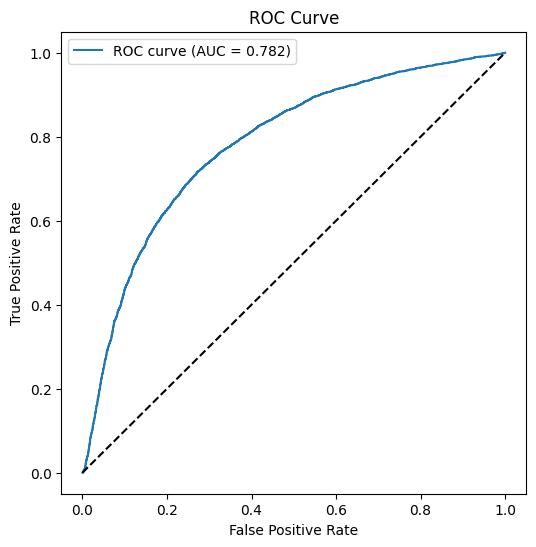

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC-AUC
auc = roc_auc_score(Y_train, y_pred_prob)
print(f"ROC-AUC: {auc:.3f}")

fpr, tpr, thresholds = roc_curve(Y_train, y_pred_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Temos uma área sob curva de 0.782. Nada mau! Certamente há margem para melhora, mas o modelo é certamente melhor do que valores aleatórios.

Agora, porém, vamos ver como o modelo de comporta com os dados de teste

## Validação com dados de teste

Façamos uma validação cruzada com os dados de teste que reservamos, para ver o quão vulnerável a overfitting nosso modelo é. Primeiro, façamos o fitting:

In [37]:
y_pred_prob = result.predict(X_test)

y_pred_class = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(Y_test, y_pred_class)

cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
cm_df

,Pred 0,Pred 1
Actual 0,1150,483
Actual 1,439,1114


A performance parece no mínimo comparável com os dados de treinamento. As medidas de acurácia, precisão, recall e F-1 ajudarão a confirmar isso.

In [38]:
accuracy = accuracy_score(Y_test, y_pred_class)
precision = precision_score(Y_test, y_pred_class)
recall = recall_score(Y_test, y_pred_class)
f1 = f1_score(Y_test, y_pred_class)

print(f"\nAccuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")



Accuracy: 0.711
Precision: 0.698
Recall: 0.717
F1 Score: 0.707


A perda foi relativamente pequena! Nosso modelo pode melhorar, mas há indícios de que tem um bom valor preditivo. Confirmemes com o ROC-AUC:

ROC-AUC: 0.766


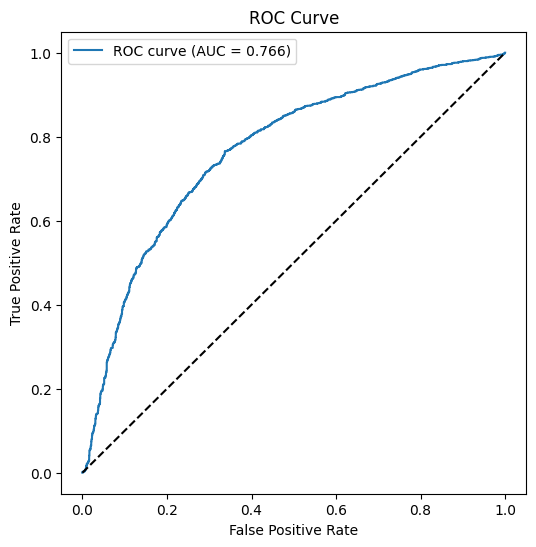

In [39]:
# Compute ROC-AUC
auc = roc_auc_score(Y_test, y_pred_prob)
print(f"ROC-AUC: {auc:.3f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Novamente, temos uma perfirmance com os dados de teste bem comparável com os dados de treinamento, com perda de cerca de 2 pontos percentuais.

# Conclusão

Conseguimos um modelo cuja performance, em várias métricas, se situa por volta de 75%, com performance bem similar quando fazemos valição cruzada. Essa é uma performance que pode ser melhorada, mas já demonstra bom poder de previsão. A análise dos dados, seleção e processamento cuidadoso dos fatores mostraram-se bem relevantes para esse resultado. Como possível trabalho futuro, é possível pensar em se explorar ainda mais possibilidades de preprocessamento para obter rsultados ainda melhores.